# LLMs Project
## Goal
Use transfer learning of GPT-2 (Generative Pre-trained Transformer 2) and vitamins ans suplements information to train a chat bot in a specific scenario

Install dependencies

In [ ]:
!pip install datasets

In [ ]:
!pip install transformers
!pip install datasets
!pip install gradio

###Data Prep
Prepares the data for fine-tuning a GPT-2 model. It reads a JSON file with prompts and completions, tokenizes the text, creates a dataset object that can be used for training, and sets up configurations for saving the output and logs. The dataset class ensures that the GPT-2 model receives the appropriate input and labels for training

In [ ]:
import json
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import evaluate
import os
os.environ["WANDB_DISABLED"] = "true"

# Input JSON file configuration
JSON_FILE = 'data.json'
OUTPUT_DIR = './gpt2-finetuned'
LOGGING_DIR = './logs'

# Load the JSON file
with open(JSON_FILE, 'r') as file:
    data = json.load(file)

# Extract and concatenate the content of 'prompt' and 'completion'
texts = [f"{item['prompt']} {item['completion']}" for item in data]

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# Tokenize the texts
encodings = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=128)

# Prepare the dataset
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']

        # Use input_ids as labels for language modeling
        self.labels = self.input_ids.clone()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


###Model Fined tunning

The model is defined using GPT2LMHeadModel, to train using 15 epochs, and a learning rate of 5e-5

In [ ]:
import matplotlib.pyplot as plt

class LossAccuracyHistoryCallback(TrainerCallback):
    def __init__(self):
        self.steps = []
        self.loss_history = []
        self.accuracy_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.global_step is not None:
            self.steps.append(state.global_step)
            self.loss_history.append(logs.get('eval_loss', None))
            self.accuracy_history.append(logs.get('eval_accuracy', None))

    def plot_loss_accuracy(self):
        # Filter out None values
        filtered_steps_loss = [(s, l) for s, l in zip(self.steps, self.loss_history) if l is not None]
        filtered_steps_accuracy = [(s, a) for s, a in zip(self.steps, self.accuracy_history) if a is not None]

        # Separate steps and corresponding loss/accuracy values after filtering
        valid_steps_loss, valid_loss = zip(*filtered_steps_loss)
        valid_steps_accuracy, valid_accuracy = zip(*filtered_steps_accuracy)

        # Plot loss history
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(valid_steps_loss, valid_loss, label='Loss', color='blue')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.legend()

        # Plot accuracy history
        plt.subplot(1, 2, 2)
        plt.plot(valid_steps_accuracy, valid_accuracy, label='Accuracy', color='orange')
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Accuracy History')
        plt.legend()

        plt.tight_layout()
        plt.show()


the function **compute_metrics** is used in the context of evaluating machine learning models, particularly in scenarios where model performance needs to be assessed based on classification accuracy. It's designed to work with the outputs of evaluation phases in machine learning workflows, where logits are model outputs and labels are the ground truth values.








In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convertir logits a tensor si es numpy.ndarray
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)

    # Convertir labels a tensor si es numpy.ndarray
    if isinstance(labels, np.ndarray):
        labels = torch.from_numpy(labels)

    # Convertir logits a etiquetas de clase
    predictions = torch.argmax(logits, dim=-1)

    # Aplanar los tensores de predicciones y etiquetas si están en formato secuencia
    predictions = predictions.view(-1)
    labels = labels.view(-1)

    # Asegúrate de que las dimensiones coincidan
    assert predictions.size() == labels.size(), "Predictions and labels must have the same size"

    # Asegúrate de que predictions y labels sean del tipo correcto
    predictions = predictions.long().cpu().numpy()
    labels = labels.long().cpu().numpy()

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}


###Model Training

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
10,5.421700,5.836594,0.000000
20,4.987800,4.960796,0.000000
30,4.191600,3.629441,0.000000
40,3.105500,2.348856,0.005244
50,2.175300,1.621000,0.364155
60,1.699200,1.418485,0.371290
70,1.519400,1.266930,0.371718
80,1.344300,1.143261,0.371718
90,1.211700,1.046265,0.371825
100,1.061300,0.978392,0.371825


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

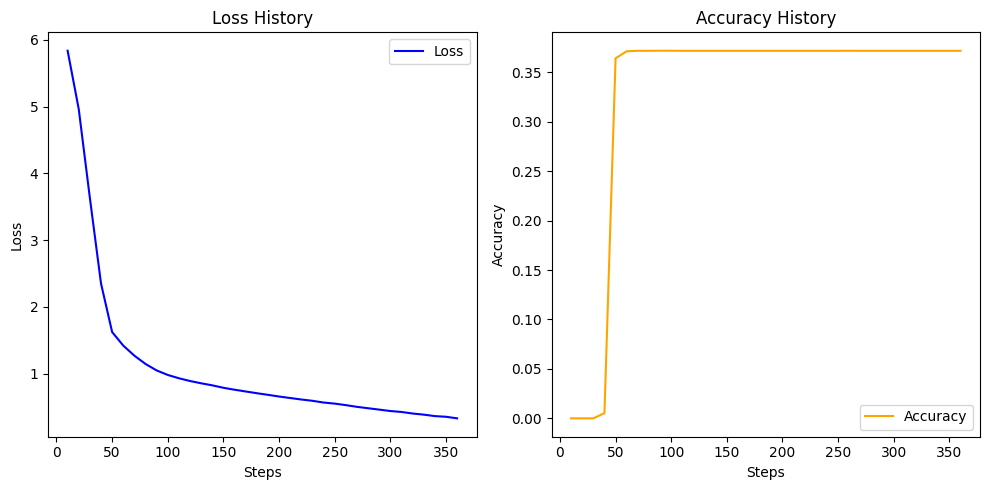

In [ ]:
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments
import evaluate
import torch
# Crear el dataset (asegúrate de que encodings esté definido correctamente)
dataset = TextDataset(encodings)

# Cargar el modelo GPT-2
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Cargar la métrica de precisión
accuracy_metric = evaluate.load("accuracy")

# Instanciar el callback personalizado
loss_accuracy_callback = LossAccuracyHistoryCallback()

# Configurar los argumentos del entrenamiento
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=8,
    num_train_epochs=15,
    logging_dir=LOGGING_DIR,
    logging_steps=10,
    evaluation_strategy="steps",  # Evaluar en cada logging step
    save_steps=10_000,
    save_total_limit=2,
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.01
)

# Configurar el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    compute_metrics=compute_metrics,
    callbacks=[loss_accuracy_callback]  # Asegúrate de usar la misma instancia del callback
)

# Iniciar el entrenamiento
trainer.train()

# Graficar la pérdida y la precisión al finalizar el entrenamiento
loss_accuracy_callback.plot_loss_accuracy()


Save the model to use later

In [ ]:
# Save the model and tokenizer
model.save_pretrained('./results')
tokenizer.save_pretrained('./results')


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.json',
 './results/merges.txt',
 './results/added_tokens.json')

In [ ]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 49.9 MB/s eta 0:00:00


###Response generation using chat bot

In [ ]:
import gradio as gr
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the tokenizer and the fitted model
tokenizer = GPT2Tokenizer.from_pretrained('./results')
model = GPT2LMHeadModel.from_pretrained('./results')
tokenizer.pad_token = tokenizer.eos_token

def generar_respuesta(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=100,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.95
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return response

# Create the interface with Gradio
iface = gr.Interface(fn=generar_respuesta, inputs="text", outputs="text", title="Chatbot")
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://182124d255e5e056ff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


###Conclusion
By using pre-trained LLM models, fine-tuning or transfer learning can be applied to leverage the knowledge of these models and adapt them to a specific domain. In this use case, training was applied to data related to dietary supplements and vitamins, resulting in accurate responses at first glance.
